In [1]:
import keras
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from keras.callbacks import ModelCheckpoint, EarlyStopping
# %reload_ext mermaid
# import IPython
# IPython.load_ipython_extensions(["nb-mermaid/nb-mermaid"]);

Using TensorFlow backend.


In [2]:
import tensorflow  as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D,Reshape, Dropout, Dense, BatchNormalization, Input, Flatten, MaxPooling2D, UpSampling2D,Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adadelta, SGD, Adam
from keras.utils import to_categorical
import keras.backend as K

In [3]:
tf_config = tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.Session(config=tf_config)
K.set_session(s)

In [4]:
csv_data = pd.read_csv('AND_Features.csv')

In [5]:
display(csv_data.head()), csv_data.shape

,Unnamed: 0,ImageId,f1,f2,f3,f4,f5,f6,f7,f8,f9
0,0,0359a,2,1,1,0,2,2,0,2,2
1,1,0577a,2,1,1,0,2,2,0,1,2
2,2,1120a,2,1,1,3,2,2,0,2,2
3,3,1120b,1,1,1,0,2,2,0,2,2
4,4,1120c,2,1,1,0,2,2,0,0,2


(None, (1026, 11))

In [6]:
image_path = 'cleaned_AND_data_64x64/'
images = os.listdir(image_path)
len(images)

13850

In [7]:
images = pd.DataFrame(np.array(images), columns=['image'])
images.shape

(13850, 1)

In [8]:
csv_data[csv_data['ImageId']=='0344c']
list(images[images['image'].str.match('0344c')]['image'])

['0344c_num1.png', '0344cc_num1.png']

In [9]:
len(list(set(list(x[:4] for x in images['image'])))), len(list(set(list(x[:4] for x in csv_data['ImageId']))))

(1532, 462)

In [10]:
dataset_columns = csv_data.columns
display(csv_data.head(20))
csv_data.shape

,Unnamed: 0,ImageId,f1,f2,f3,f4,f5,f6,f7,f8,f9
0,0,0359a,2,1,1,0,2,2,0,2,2
1,1,0577a,2,1,1,0,2,2,0,1,2
2,2,1120a,2,1,1,3,2,2,0,2,2
3,3,1120b,1,1,1,0,2,2,0,2,2
4,4,1120c,2,1,1,0,2,2,0,0,2
5,5,1121a,2,1,1,3,2,2,0,1,2
6,6,1121b,2,1,1,0,2,2,0,3,2
7,7,1121c,1,1,1,0,2,2,0,1,2
8,8,1229b,1,1,1,3,2,2,0,2,2
9,9,1302a,2,1,1,3,2,2,0,0,2


(1026, 11)

In [11]:
train_csv_data =  csv_data[:700]
val_csv_data =  csv_data[700:]
train_csv_data.shape, val_csv_data.shape

((700, 11), (326, 11))

In [12]:
f = []
for col in dataset_columns[2:]:
    f.append(csv_data[col].unique().shape[0])
f

[4, 5, 3, 5, 4, 4, 4, 5, 2]

In [13]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format
original_dim = 4096
latent_dim = 32
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
epochs = 50

inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)


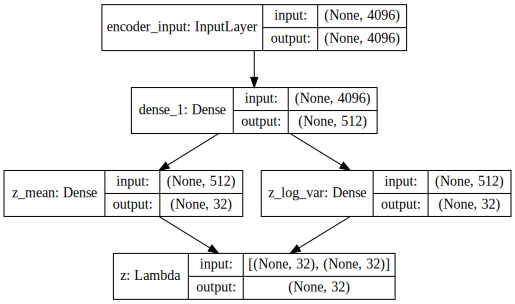

In [14]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
SVG(model_to_dot(encoder, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

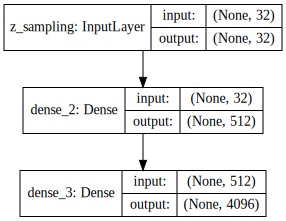

In [15]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs) # decoder_h
outputs = Dense(original_dim, activation='sigmoid')(x) # decoder_mean

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
SVG(model_to_dot(decoder, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

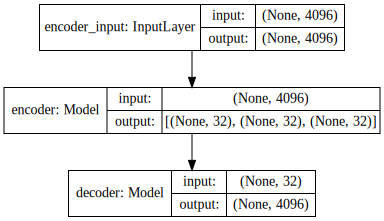

In [16]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
SVG(model_to_dot(vae, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [17]:
from keras.losses import mse
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 4096)              0         
_________________________________________________________________
encoder (Model)              [(None, 32), (None, 32),  2130496   
_________________________________________________________________
decoder (Model)              (None, 4096)              2118144   
Total params: 4,248,640
Trainable params: 4,248,640
Non-trainable params: 0
_________________________________________________________________


In [18]:

def datagen(batch_size,list_of_writers,vis=False):
    counter = 0
    
    
    while counter <= batch_size:
        counter = 0
        # for writer in unique_writers:
        #     print(identitycounter*100/stop_at, end='\r')
        w_ids,ids = [],[]
        writer_indexes = np.random.randint(0,len(list_of_writers),batch_size)
        x,f_1_out,f_2_out,f_3_out,f_4_out,f_5_out,f_6_out,f_7_out,f_8_out = [],[],[],[],[],[],[],[],[]
        for writer_index in writer_indexes:
#             class_vectors = []
            writer = list_of_writers[writer_index]
#             print(writer)
            writer_samples = list(images[images['image'].str.match(writer)]['image'])
#             print('writer:',writer,', writer_samples:',writer_samples)
            if len(writer_samples) == 0:
                continue
            writer_sample_index = np.random.randint(0,len(writer_samples))

            #     unique_writers_count[writer] = len(writer_samples)
#             print('writer_sample_index:',writer_sample_index)
            csv_writer = writer_samples[writer_sample_index][:5]

    
            loaded_image = cv2.imread(os.path.join(image_path,writer_samples[writer_sample_index]),0)
            loaded_image = np.expand_dims(loaded_image,-1)
#             print('csv_writer:', csv_writer, ', writer:', writer)
#             display(csv_data[csv_data['ImageId'].str.match(csv_writer)])
#             csv_discreete_features = csv_data[csv_data['ImageId'].str.match(csv_writer)].iloc[0].values[2:]
#             print(csv_writer, writer_samples[writer_sample_index])
#             print(csv_writer,csv_discreete_features)
#             for i in range(1,9):
#                 print(csv_discreete_features[i-1],end=',')
#             f_1_out.append(csv_discreete_features[0])
#             f_2_out.append(csv_discreete_features[1])
#             f_3_out.append(csv_discreete_features[2])
#             f_4_out.append(csv_discreete_features[3])
#             f_5_out.append(csv_discreete_features[4])
#             f_6_out.append(csv_discreete_features[5])
#             f_7_out.append(csv_discreete_features[6])
#             f_8_out.append(csv_discreete_features[7])
#                 class_vectors.append(to_categorical(csv_discreete_features[i-1],num_classes=feature_lengths['f'+str(i)]))
#             print("\n",len(class_vectors))
#             print('\n-----------')
            
#             print("++++++++++++++++++++++[",counter,"]+++++++++++++++++++++++")
        #     imgcounter = 0
        #     for sample in writer_samples:
        #         imagepath = os.path.join(image_path,sample)
        #         raw_img = cv2.imread(imagepath)
        #         imgcounter+=1
        #     imgcounter=0
        #     identitycounter += 1
            x.append(255.0-loaded_image.reshape((64*64)))
            w_ids.append(writer[:4])
            ids.append(writer_index)
            
            counter+=1
#             print('counter:', counter, end='\r')
        if vis== True:
            yield np.array(x)/255.0,[np.array(w_ids),np.array(ids)]
        else:
            yield np.array(x)/255.0,None
                    

In [ ]:
# # unique_writers_count
# f_count = {}
train_list_of_writers = train_csv_data['ImageId'].unique()
val_list_of_writers = val_csv_data['ImageId'].unique()
batch_size = 64

tg = datagen(batch_size,train_list_of_writers)
vg = datagen(batch_size,val_list_of_writers)


In [ ]:
# images
inputs,y = next(tg)
inputs.shape , y#, o[0].shape #, o[1].shape,o[2].shape,o[3].shape,o[4].shape,o[5].shape,o[6].shape,o[7].shape

((64, 4096), None)

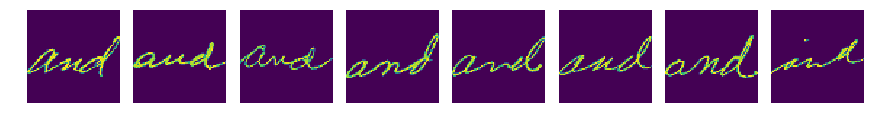

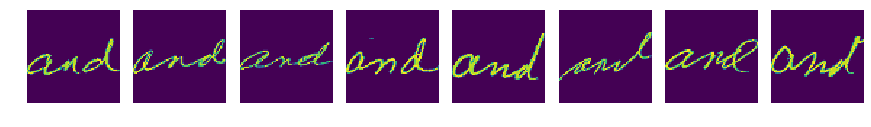

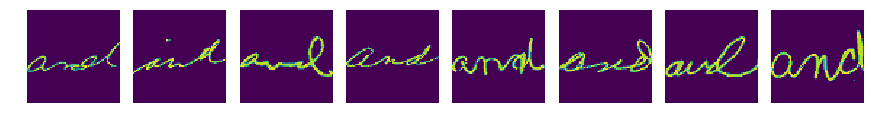

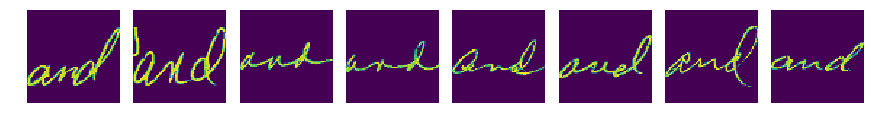

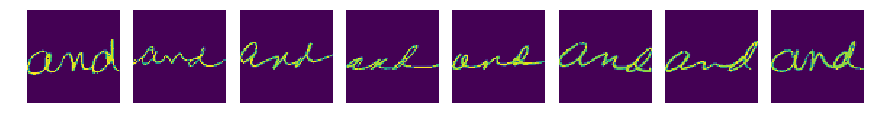

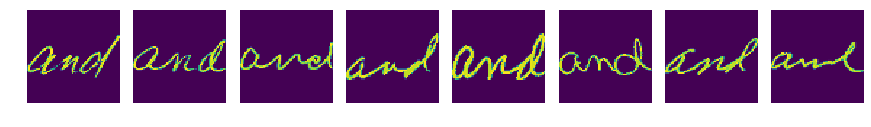

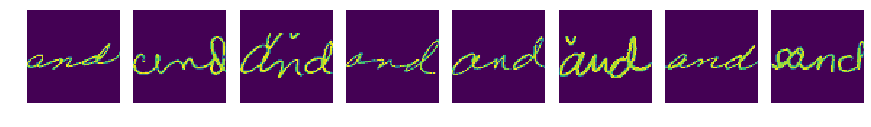

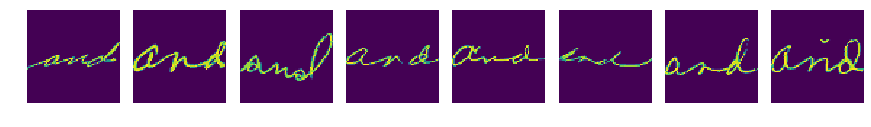

In [ ]:
for r in range(8):
    f,ax = plt.subplots(1,8)
    f.subplots_adjust(hspace = .00, wspace=.15)
    f.set_size_inches(15,5)
    for c in range (8):
        ax[c].imshow(inputs[c+r*8].reshape((64,64)))
        ax[c].axis('off')

In [ ]:
mc = ModelCheckpoint(filepath='vae_weights_v2.h5', monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = EarlyStopping(patience=1000, monitor='val_loss', min_delta=0.0005, mode='auto')

In [ ]:
EPOCHS = 5000
hist = vae.fit_generator(tg, callbacks=[mc,es]
                                    , epochs=EPOCHS
                                    , steps_per_epoch = 1
                                    , validation_data = vg
                                    , validation_steps = 1
                                    , verbose = 3
                                    
                                   )

Epoch 1/5000

Epoch 00001: val_loss improved from inf to 932.99817, saving model to vae_weights_v2.h5
Epoch 2/5000

Epoch 00002: val_loss improved from 932.99817 to 870.57104, saving model to vae_weights_v2.h5
Epoch 3/5000

Epoch 00003: val_loss improved from 870.57104 to 771.67358, saving model to vae_weights_v2.h5
Epoch 4/5000

Epoch 00004: val_loss improved from 771.67358 to 640.12189, saving model to vae_weights_v2.h5
Epoch 5/5000

Epoch 00005: val_loss improved from 640.12189 to 481.72394, saving model to vae_weights_v2.h5
Epoch 6/5000

Epoch 00006: val_loss improved from 481.72394 to 386.08618, saving model to vae_weights_v2.h5
Epoch 7/5000

Epoch 00007: val_loss improved from 386.08618 to 348.12054, saving model to vae_weights_v2.h5
Epoch 8/5000

Epoch 00008: val_loss improved from 348.12054 to 333.94623, saving model to vae_weights_v2.h5
Epoch 9/5000

Epoch 00009: val_loss improved from 333.94623 to 312.72842, saving model to vae_weights_v2.h5
Epoch 10/5000

Epoch 00010: val_lo


Epoch 00107: val_loss improved from 140.50607 to 138.45647, saving model to vae_weights_v2.h5
Epoch 108/5000

Epoch 00108: val_loss did not improve from 138.45647
Epoch 109/5000

Epoch 00109: val_loss did not improve from 138.45647
Epoch 110/5000

Epoch 00110: val_loss did not improve from 138.45647
Epoch 111/5000

Epoch 00111: val_loss did not improve from 138.45647
Epoch 112/5000

Epoch 00112: val_loss did not improve from 138.45647
Epoch 113/5000

Epoch 00113: val_loss did not improve from 138.45647
Epoch 114/5000

Epoch 00114: val_loss did not improve from 138.45647
Epoch 115/5000

Epoch 00115: val_loss did not improve from 138.45647
Epoch 116/5000

Epoch 00116: val_loss did not improve from 138.45647
Epoch 117/5000

Epoch 00117: val_loss did not improve from 138.45647
Epoch 118/5000

Epoch 00118: val_loss did not improve from 138.45647
Epoch 119/5000

Epoch 00119: val_loss did not improve from 138.45647
Epoch 120/5000

Epoch 00120: val_loss improved from 138.45647 to 136.41234, s

In [ ]:
df_hist = pd.DataFrame(hist.history)
df_hist.plot(subplots=True, figsize=(15,100))
print(df_hist['val_loss'].min())
df_hist[df_hist['val_loss']<10.2]

In [ ]:
# human_features.load_weights('human_features_weights_v2.h5')

In [ ]:
# # print(df_hist.columns)
# print(df_hist['val_out_feature_1_acc'].max(), df_hist['val_out_feature_2_acc'].max(),
#        df_hist['val_out_feature_3_acc'].max(), df_hist['val_out_feature_4_acc'].max(),
#        df_hist['val_out_feature_5_acc'].max(), df_hist['val_out_feature_6_acc'].max(),
#        df_hist['val_out_feature_7_acc'].max(), df_hist['val_out_feature_8_acc'].max())
# # df_hist[df_hist['val_acc']>10.2]

In [ ]:
batch_size = 10
test_list_of_writers = val_csv_data['ImageId'].unique()[:2]
print(test_list_of_writers)
test_g = datagen(batch_size,test_list_of_writers, vis=True)
inputs,y = next(test_g)
x_test_encoded = encoder.predict(inputs, batch_size=batch_size)


In [ ]:
display(csv_data[csv_data['ImageId']=='0564a'])
list(images[images['image'].str.match('0564a')]['image'])

In [ ]:
y[0]

In [ ]:
np.array(x_test_encoded).shape

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(x_test_encoded[0][:, 0], x_test_encoded[0][:, 1],c=y[1])
plt.colorbar()
plt.show()

In [ ]:
encoder.predict(inputs)[0]

In [ ]:
plt.imshow(inputs[0].reshape((64,64)))

In [ ]:
plt.imshow(inputs[1].reshape((64,64)))

In [ ]:
plt.imshow(inputs[2].reshape((64,64)))

In [ ]:
plt.imshow(inputs[8].reshape((64,64)))

In [ ]:
from sklearn.metrics import euclidean_distances

In [ ]:
ed = euclidean_distances(encoder.predict(inputs)[0])

In [ ]:
pd.DataFrame(ed)

In [ ]:
y[1]